# Factor regressions

Begin by downloading data from the [Fama-French Data Library](https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html) using `pandas_datareader`.

In [9]:
import pandas_datareader as pdr

In [11]:
ff = pdr.get_data_famafrench('F-F_Research_Data_Factors', 1926)

The returned result is a dictionary:

In [14]:
type(ff)

dict

In [16]:
ff.keys()

dict_keys([0, 1, 'DESCR'])

In [18]:
print(ff['DESCR'])

F-F Research Data Factors
-------------------------

This file was created by CMPT_ME_BEME_RETS using the 202312 CRSP database. The 1-month TBill return is from Ibbotson and Associates, Inc. Copyright 2023 Kenneth R. French

  0 : (1170 rows x 4 cols)
  1 : Annual Factors: January-December (97 rows x 4 cols)


The data we want is stored in the dictionary element with a key of `0`. We'll just write over our `ff` dictionary with the `DataFrame` we want.

In [20]:
ff = ff[0]

ff

,Mkt-RF,SMB,HML,RF
Date,,,,
1926-07,2.96,-2.56,-2.43,0.22
1926-08,2.64,-1.17,3.82,0.25
1926-09,0.36,-1.40,0.13,0.23
1926-10,-3.24,-0.09,0.70,0.32
1926-11,2.53,-0.10,-0.51,0.31
...,...,...,...,...
2023-08,-2.39,-3.16,-1.06,0.45
2023-09,-5.24,-2.51,1.52,0.43
2023-10,-3.19,-3.87,0.19,0.47


## Market, Size, and Value factors

The data contain monthly returns on four assets:

- **Mkt-RF** is return on the market portfolio in excess of the riskfree rate. The market portfolio is the CRSP value-weighted portfolio, which includes all stocks traded on U.S. public markets, but uses market-capitalization to weight returns. That is, large stocks have more of an impact on the return of the portfolio than small stocks. This factor is usually referred to as **RMRF**.

- **SMB** (“small-minus-big”) is the return on a portfolio that is long *small* stocks and short *big* stocks.

- **HML** (“high-minus-low”) is the return on a portfolio that is long *value* stocks and short *growth* stocks.

- **RF** is the riskfree rate, which is proxied by the 1-month T-Bill.

RMRF, SMB, and HML are known as *factor-mimicking portfolios*. That is, they are portfolios whose returns are meant to mimick the returns of some underlying economic factor.

The SMB and HML portfolios are constructed from six underlying portfolios that include stocks based on two characteristics:

- **Size** is the market capitalization of the company, equal to number of shares outstanding times the share price;

- **Book-to-market** is the book value of equity divided by market value of equity.

At each point in time, firms with below-median size are called “small” and those above the median are “big”. On the book-to-market dimension, firms are divided into three groups (below 30th percentile, between the 30th and 70th percentile, and above the 70th percentile.) Those with the highest book-to-market are called “value” stocks, while those with the lowest book-to-market are “growth” stocks. Stocks with high book-to-market are typically companies with lots of physical assets but not a lot of growth opportunities, like a utility company. Stocks with low book-to-market are those with a lot of market value relative to their assets, which usually means they have a lot of growth opportunities that make investors willing to pay relatively high prices today to buy shares.

|         | Small         | Big         |
|---------|---------------|-------------|
| **Value**   | Small Value   | Big Value   |
| **Neutral** | Small Neutral | Big Neutral |
| **Growth**  | Small Growth  | Big Growth  |

The factors are then long-short portfolios that combine these six building block portfolios differently. The size factor is

\begin{multline*}
SMB = \frac{1}{3}(\text{Small Value} + \text{Small Neutral} + \text{Small Growth}) \\
- \frac{1}{3}(\text{Big Value} + \text{Big Neutral} + \text{Big Growth}),
\end{multline*}

and the value factor is

$$HML = \frac{1}{2}(\text{Small Value} + \text{Big Value}) - \frac{1}{2}(\text{Small Growth} + \text{Big Growth}).$$

All three factors mimicking are *arbitrage*, *self-financing*, or *zero net-investment* portfolios. While it may be hard to implement for a small investor, theoretically these portfolios could be constructed with no investment — you pay for the long side with funds generated from the short side. With RMRF, for example, we would borrow at the riskfree rate to invest in the market portfolio.

## Historical returns

The data from the Fama–French library are in percent, so the 2.96 in July 1926 means the return that month was 2.96%. To make these consistent with other data we'll be using, we'll divide by 100.

In [22]:
ff = ff.rename({'Mkt-RF':'RMRF'}, axis='columns')

In [24]:
ff = ff / 100

In [26]:
ff.describe()

,RMRF,SMB,HML,RF
count,1170.000000,1170.000000,1170.000000,1170.000000
mean,0.006781,0.001863,0.003480,0.002677
std,0.053446,0.031728,0.035687,0.002507
min,-0.291300,-0.172000,-0.138700,-0.000600
25%,-0.020200,-0.016200,-0.013975,0.000300
50%,0.010600,0.000800,0.001300,0.002200
75%,0.036500,0.017500,0.017500,0.004200
max,0.388500,0.365600,0.356100,0.013500


Given monthly returns, the annual return can be approximated as $12 \times R_t$, where $R_t$ is the return in month $t$.

In [29]:
12 * ff.mean()

RMRF    0.081368
SMB     0.022354
HML     0.041755
RF      0.032120
dtype: float64

The variance of the annual return is

$$12\times\var(R_t),$$

so the volatility is

$$\sqrt{12}\times \sigma_R.$$

In [32]:
np.sqrt(12) * ff.std()

RMRF    0.185142
SMB     0.109908
HML     0.123623
RF      0.008685
dtype: float64

So on an annualized basis over the last 100 years, the market factor has earned a return of about 8% with a volatility of a little less than 0.2.

The Sharpe ratio is simply the average portfolio return divided by its volatility:

In [36]:
ff.mean() / ff.std()

RMRF    0.126870
SMB     0.058713
HML     0.097503
RF      1.067652
dtype: float64

On an annualized basis, this means we multiply by $\sqrt{12}$.

In [39]:
np.sqrt(12) * ff.mean() / ff.std()

RMRF    0.439491
SMB     0.203386
HML     0.337760
RF      3.698454
dtype: float64

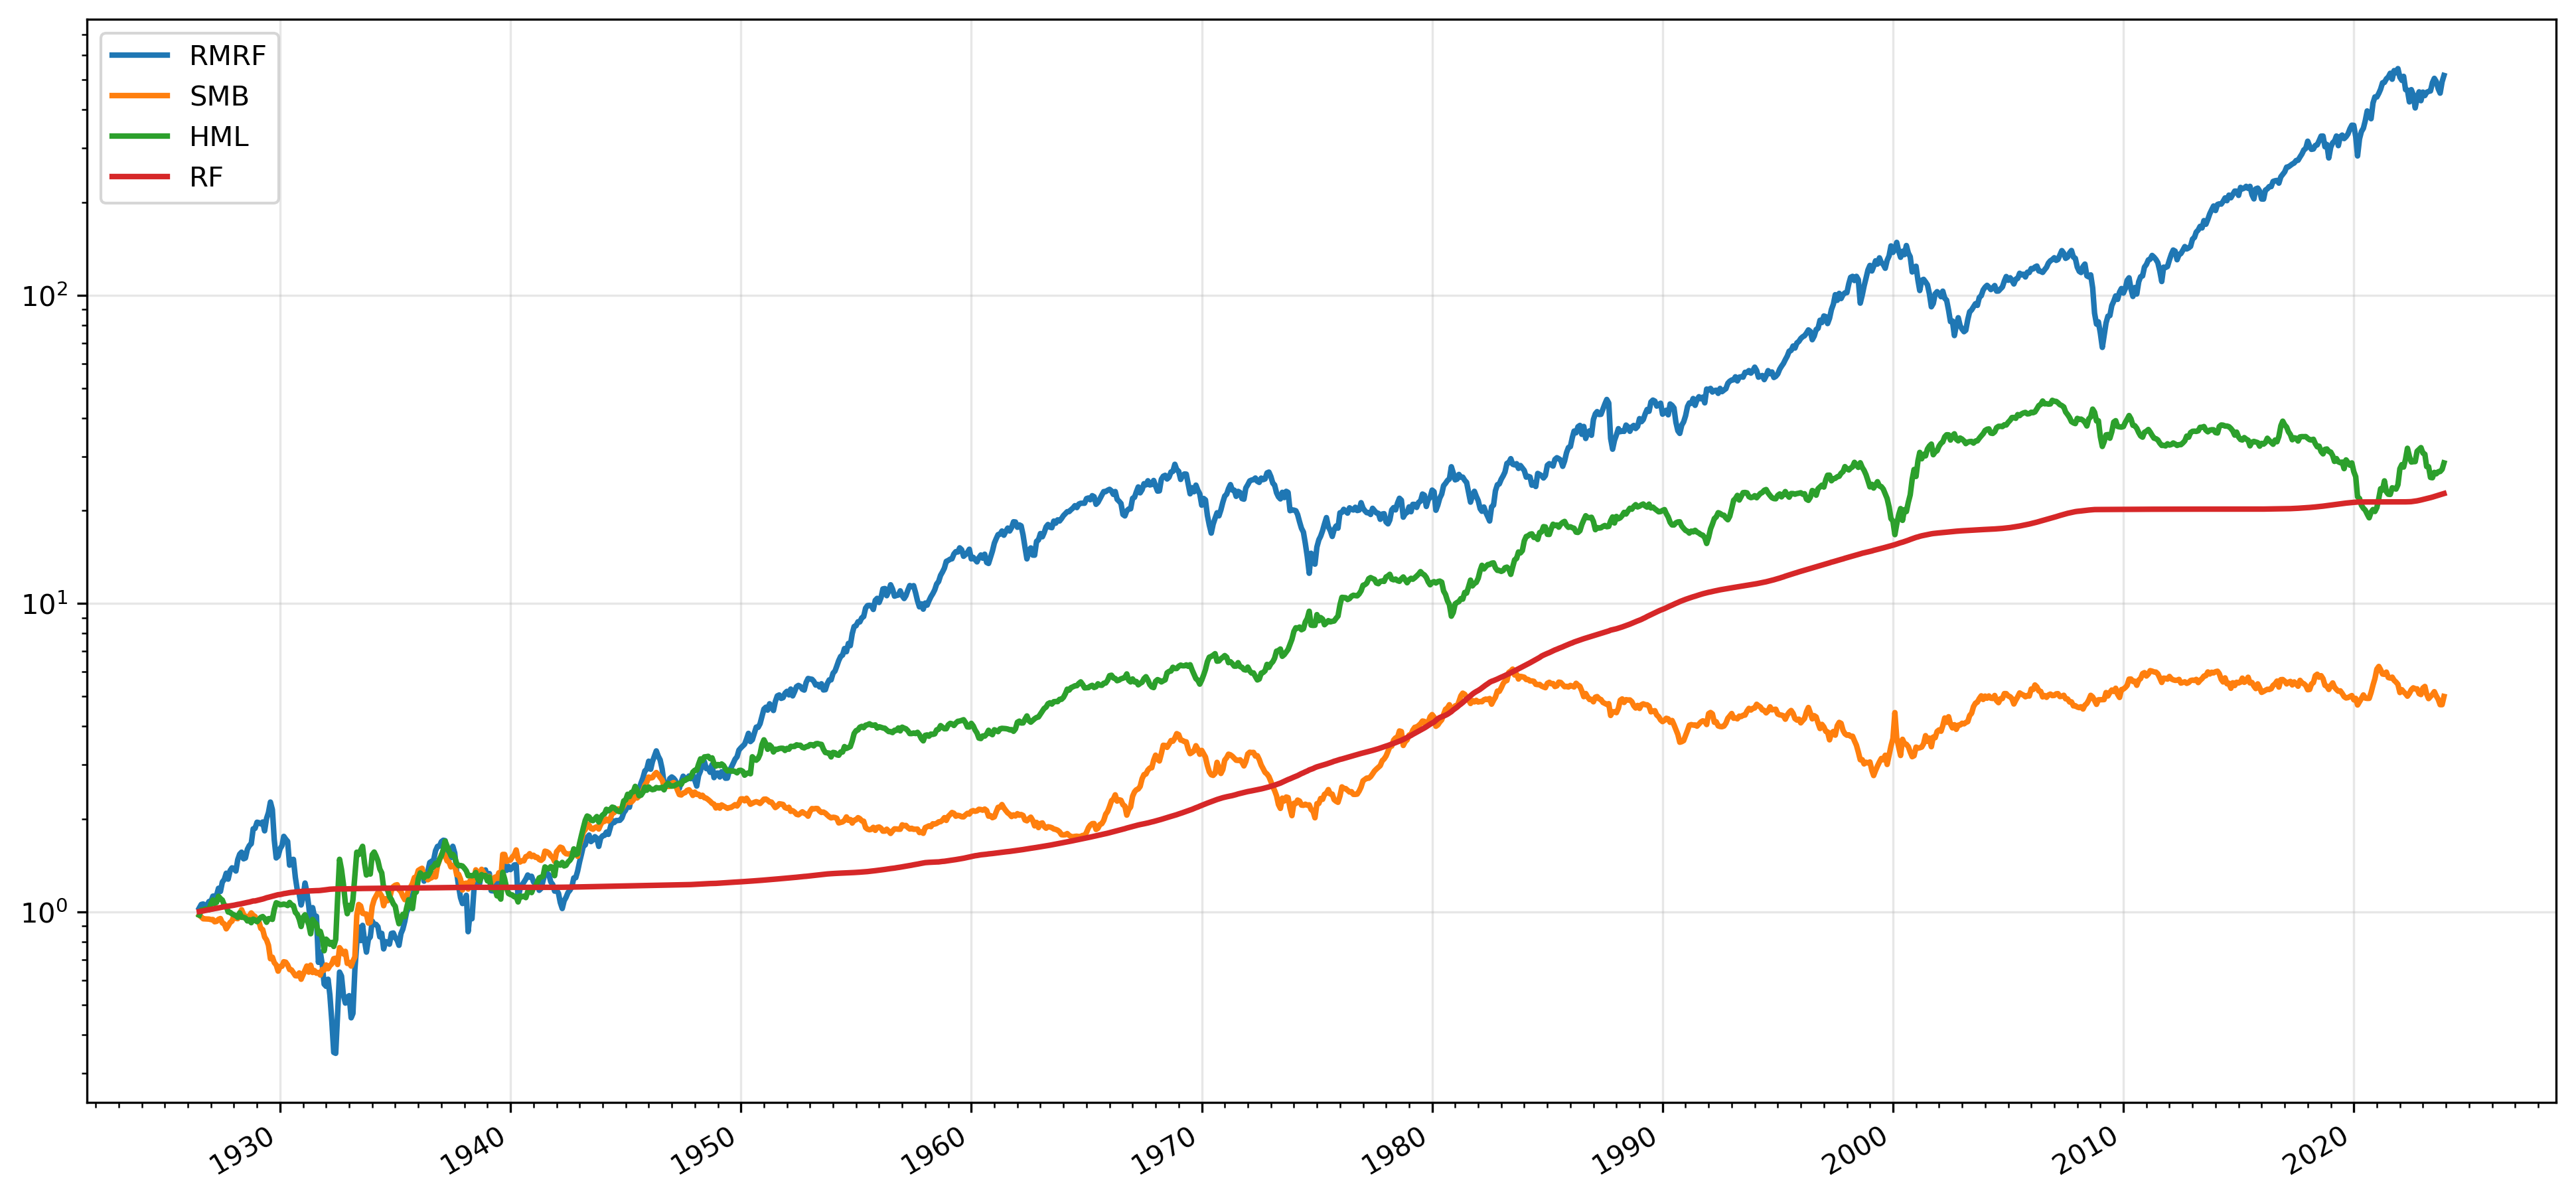

In [41]:
fig, ax = plt.subplots()

(1+ff).cumprod().plot(figsize=(16,8), lw=2, ax=ax, logy=True, xlabel='', x_compat=True)

# change year locations
from matplotlib.dates import YearLocator
ax.xaxis.set_major_locator(YearLocator(10))
ax.xaxis.set_minor_locator(YearLocator(1))

ax.grid(alpha=0.3)
ax.legend(loc='upper left')
plt.show()

## The one-factor model: CAPM

The Capital Asset Pricing Model (CAPM) says that an asset's expected return depends on its *beta*, denoted $\beta$. That is,

$$\E(R^e_i) = \beta_i \, \E(R_M^e),$$

where $R^e_i := R_i - R_f$ is the *excess return* on asset $i$ and $R_M$ is the return on the market portfolio.

The CAPM is a *one-factor* model, where the market portfolio is the single factor — the fundamental source of risk in the economy. A factor model of returns says that the returns on an asset come from:

1. How much return we get from being exposed to any *risk factor*. In the CAPM, this is $\E(R_M^e)$, the expected excess return from holding the market.

2. How much exposure to a factor we get from holding a particular asset. This is the asset's beta, $\beta_i$. It is also called the *factor loading*. If a stock has high factor loadings, it gives high exposure to the underlying source of risk and is therefore riskier than a stock that has a low factor loading. So high-beta stocks are riskier than low-beta stocks. This is why we say beta is a measure of an asset's risk.

We saw that historically, the market portfolio has earned an excess return of about 8% per year. If an investor just holds the market portfolio, this is the return they earn for bearing market risk. An investor can earn a higher return by buying a stock with $\beta_i>1$, allowing them to load up on more of the risk factor. If the investor wants to own a stocks with less risk, she buys a stock with $\beta_i<1$ (and therefore earn a return below that of the market.

### What is risk?

The CAPM says that a high-beta stock should earn a higher return than a low beta stock. As long as arbitrage opportunities are not common in financial markets, we can only earn higher returns by taking on more risk. Therefore, the higher returns from high betas must be due to higher risk. But why is beta a measure of risk?

It is easiest to understand this if we step back and define what we mean by risk. Economically, a risky asset is one that pays off when times are “good.” This might strange, but stop and think: if you buy an insurance contract against something bad happening, are you increasing your risk or decreasing it? You should agree that insurance reduces risk. Home insurance pays you when your house burns down. It pays off in bad times. (Insurance also has a negative expected return. It has regular negative cash flows, and with a very small probability has a large positive cash flow.)

In economic models, times are “good” when people have low *marginal utility*. Their needs are being met. They have food to eat, and so having more food won't increase their utility much. Times are “bad” when they have high marginal utility; their utility would increase a lot if they were able to consume more.

So a low-risk asset should be one that pays off when times are bad. It will allow you to buy more food precisely at the time that you are hungry, just like the insurance contract allows you to build a house when your house burns down. A high-risk asset pays off in good times, when you already have what you need and another dollar isn't going to have much of an effect on your utility.

In the CAPM, the measure of whether times are good or bad is the market portfolio. This obviously ignores all kinds of important economic information about the welfare of people in an economy, but it is the measure that CAPM uses. (There are other asset pricing models that use other proxies to measure marginal utility.)

Assets with high betas must earn higher expected returns in order to incentivise investors to own these assets. People who are risk averse are willing to hold risky assets, but must be compensated for doing so.

:::{Admonition} Key fact
:class: key-fact

In the CAPM model, the measure of an asset's risk is its beta. The bigger its beta, the more the asset loads on the single risk factor in the economy, and the higher its expected returns must be.

:::

### Estimating one-factor regressions

We can estimate an asset's $\beta$ by running a time series regression,

$$R_{i,t}^e = \alpha_i + \beta_i R_{M,t}^e + \epsilon_{i,t}.$$

The prediction of the CAPM in this context is that the $\alpha_i$ should be zero.

In [47]:
ff = pdr.get_data_famafrench('F-F_Research_Data_Factors_daily', 2000)[0]
ff = ff.rename(columns={'Mkt-RF':'RMRF'})
ff = ff / 100

As a sample of firms, we'll use historical returns on the current constitutents of the S&P 500.

In [50]:
sp500 = pd.read_csv('https://raw.githubusercontent.com/stoffprof/qf/main/data/sp500_yahoo.csv',
                    index_col='Date', parse_dates=['Date'])

rets = sp500.pct_change().dropna(how='all')

rets.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6036 entries, 2000-01-04 to 2023-12-29
Columns: 505 entries, A to ZTS
dtypes: float64(505)
memory usage: 23.3 MB


Now we'll bring in the returns on just one stock — Eli Lilly.

In [54]:
df = pd.merge(rets['LLY'], ff, left_index=True, right_index=True)

df

,LLY,RMRF,SMB,HML,RF
Date,,,,,
2000-01-04,-0.031458,-0.0406,0.0000,0.0206,0.00021
2000-01-05,0.012796,-0.0009,0.0020,0.0016,0.00021
2000-01-06,0.029155,-0.0073,-0.0043,0.0126,0.00021
2000-01-07,0.073654,0.0321,-0.0048,-0.0142,0.00021
2000-01-10,-0.041337,0.0176,0.0096,-0.0152,0.00021
...,...,...,...,...,...
2023-12-22,-0.002815,0.0021,0.0064,0.0009,0.00021
2023-12-26,0.000491,0.0048,0.0069,0.0046,0.00021
2023-12-27,0.018995,0.0016,0.0014,0.0012,0.00021


In [56]:
df['exret'] = df['LLY'] - df['RF']

df = df.dropna()  # regression doesn't work NaNs

In [58]:
df

,LLY,RMRF,SMB,HML,RF,exret
Date,,,,,,
2000-01-04,-0.031458,-0.0406,0.0000,0.0206,0.00021,-0.031668
2000-01-05,0.012796,-0.0009,0.0020,0.0016,0.00021,0.012586
2000-01-06,0.029155,-0.0073,-0.0043,0.0126,0.00021,0.028945
2000-01-07,0.073654,0.0321,-0.0048,-0.0142,0.00021,0.073444
2000-01-10,-0.041337,0.0176,0.0096,-0.0152,0.00021,-0.041547
...,...,...,...,...,...,...
2023-12-22,-0.002815,0.0021,0.0064,0.0009,0.00021,-0.003025
2023-12-26,0.000491,0.0048,0.0069,0.0046,0.00021,0.000281
2023-12-27,0.018995,0.0016,0.0014,0.0012,0.00021,0.018785


In [60]:
import statsmodels.api as sm

In [62]:
reg_model = sm.OLS(df['exret'], sm.add_constant(df['RMRF']))

reg_rslt = reg_model.fit()

print(reg_rslt.summary())

                            OLS Regression Results                            
Dep. Variable:                  exret   R-squared:                       0.224
Model:                            OLS   Adj. R-squared:                  0.224
Method:                 Least Squares   F-statistic:                     1743.
Date:                Mon, 19 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:03:26   Log-Likelihood:                 16782.
No. Observations:                6036   AIC:                        -3.356e+04
Df Residuals:                    6034   BIC:                        -3.355e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      1.913      0.0

## Fama–French 3-factor model

The 3-factor model regression equation is:

$$R_{i,t}^e = \alpha_i + \beta^M_i R_{M,t}^e + \beta^S_i R_{SMB,t} + \beta^V_i R_{HML,t} + \epsilon_{i,t}$$

In [67]:
reg_model = sm.OLS(df['exret'],
                   sm.add_constant(df[['RMRF', 'SMB', 'HML']]))

reg_rslt = reg_model.fit()

print(reg_rslt.summary())

                            OLS Regression Results                            
Dep. Variable:                  exret   R-squared:                       0.243
Model:                            OLS   Adj. R-squared:                  0.243
Method:                 Least Squares   F-statistic:                     646.1
Date:                Mon, 19 Feb 2024   Prob (F-statistic):               0.00
Time:                        20:05:07   Log-Likelihood:                 16858.
No. Observations:                6036   AIC:                        -3.371e+04
Df Residuals:                    6032   BIC:                        -3.368e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0004      0.000      2.073      0.0

Coefficient estimates, $t$-statistics, $R^2$, and residuals are all available as properties of the regression result object. We'll need these below.

In [33]:
reg_rslt.params

const    0.000300
RMRF     0.684447
SMB     -0.342549
HML     -0.078720
dtype: float64

In [34]:
reg_rslt.tvalues

const     1.533558
RMRF     43.326331
SMB     -10.997645
HML      -3.092456
dtype: float64

In [35]:
reg_rslt.rsquared

0.25422021867012323

In [71]:
reg_rslt.resid

Date
2000-01-04   -0.003358
2000-01-05    0.013650
2000-01-06    0.032736
2000-01-07    0.048715
2000-01-10   -0.051259
                ...   
2023-12-22   -0.002389
2023-12-26   -0.000452
2023-12-27    0.017920
2023-12-28   -0.002990
2023-12-29    0.001424
Length: 6036, dtype: float64

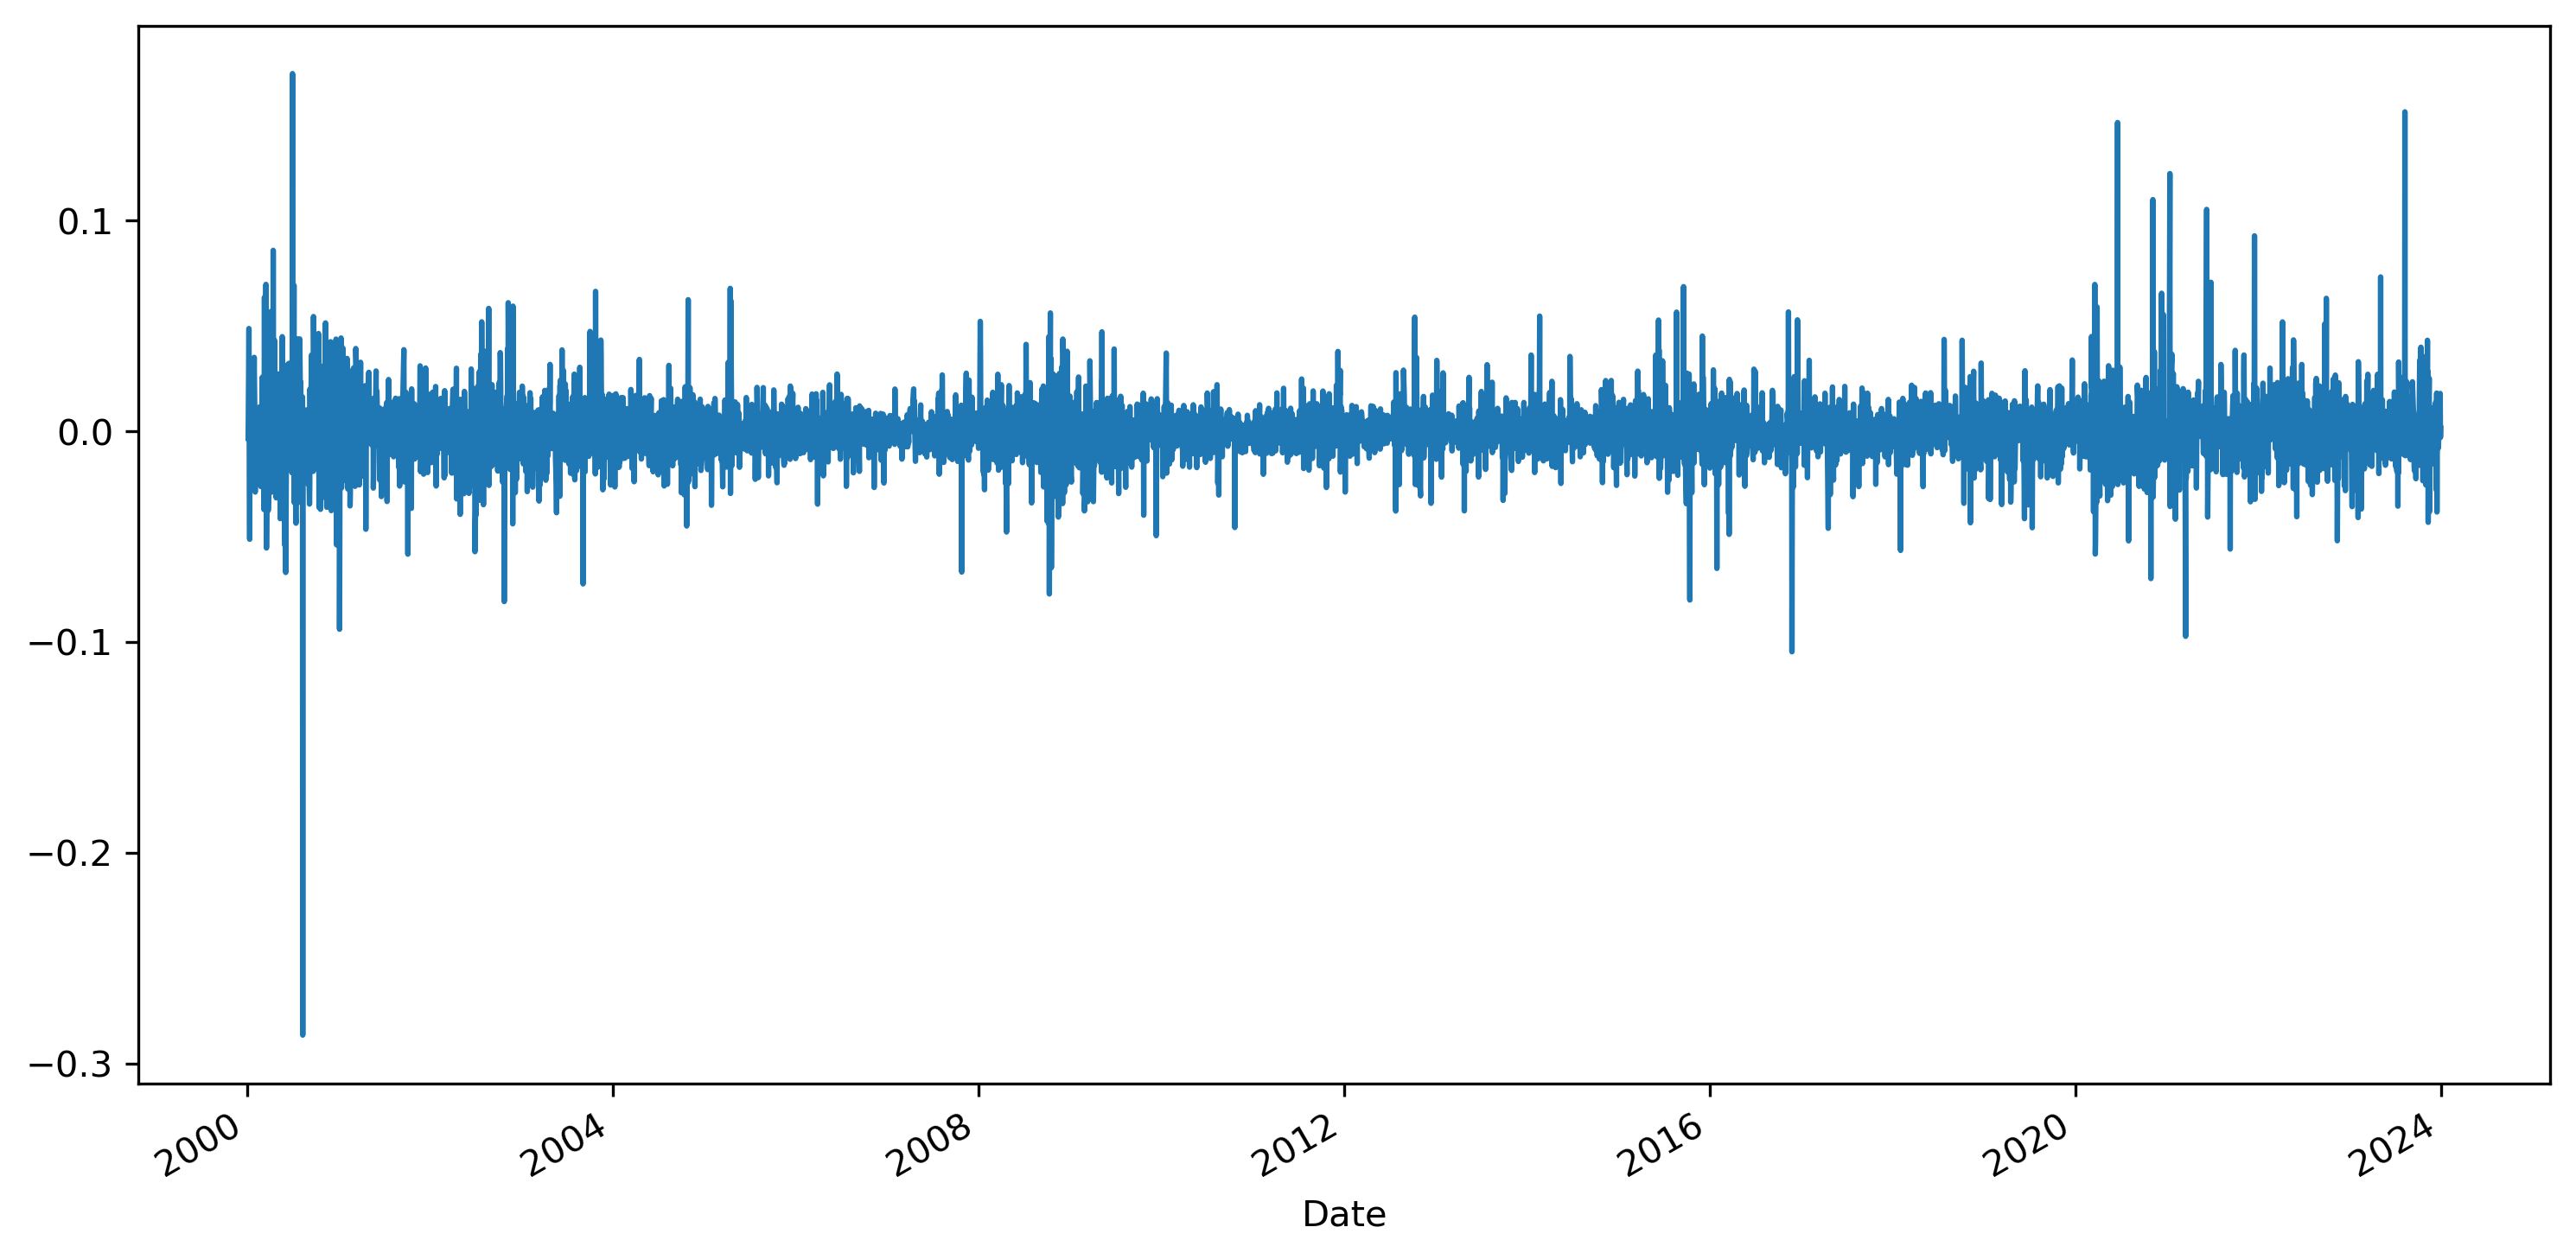

In [73]:
reg_rslt.resid.plot(figsize=(12,6));

In [77]:
# rename RF so it doesn't clash with ticker RF

ff = ff.rename(columns={'RF': 'rf'})

In [108]:
def regression(ticker):
    ticker = ticker.replace('.', '-')
    df = pd.merge(ff, rets[ticker], left_index=True, right_index=True)
    df = df.dropna()
    df['exret'] = df[ticker] - df['rf']
    reg_model = sm.OLS(df['exret'],
                       sm.add_constant(df[['RMRF', 'SMB', 'HML']]))
    reg_rslt = reg_model.fit()
    params = reg_rslt.params
    tvals = reg_rslt.tvalues
    tvals.index = map(lambda x: 't_'+x, tvals.index)  # rename t-value index values
    rslt = pd.concat([params, tvals])
    rslt['R2'] = reg_rslt.rsquared
    rslt['N'] = reg_rslt.nobs
    return(rslt, reg_rslt.resid)

In [81]:
rslt, resid = regression('LLY')

In [83]:
rslt

const         0.000396
RMRF          0.671477
SMB          -0.371588
HML          -0.070086
t_const       2.072834
t_RMRF       43.625047
t_SMB       -12.242785
t_HML        -2.873363
R2            0.243187
N          6036.000000
dtype: float64

In [85]:
resid

Date
2000-01-04   -0.003358
2000-01-05    0.013650
2000-01-06    0.032736
2000-01-07    0.048715
2000-01-10   -0.051259
                ...   
2023-12-22   -0.002389
2023-12-26   -0.000452
2023-12-27    0.017920
2023-12-28   -0.002990
2023-12-29    0.001424
Length: 6036, dtype: float64

We can now run regressions for each stock in our sample, simply by iterating over the columns of `rets` dataframe.

In [138]:
betas = {}
resids = {}
for tic in rets:
    rslt, resid = regression(tic)
    betas[tic] = rslt
    resids[tic] = resid

resids = pd.DataFrame(resids)

# transpose betas dataframe so coefficient estimates are columns
betas = pd.DataFrame(betas).T
betas

,const,RMRF,SMB,HML,t_const,t_RMRF,t_SMB,t_HML,R2,N
A,0.000113,1.242231,0.326554,-0.333180,0.432634,58.821003,7.841500,-9.955555,0.387372,6036.0
AAL,0.000213,1.396551,0.988404,1.122400,0.414356,32.909647,11.718478,17.566332,0.301725,4595.0
AAPL,0.000881,1.161871,-0.077145,-0.538053,3.471526,56.786471,-1.912089,-16.594683,0.365658,6036.0
ABBV,0.000412,0.736228,-0.236039,-0.016972,1.472884,28.602130,-5.085877,-0.511131,0.229390,2767.0
ABNB,0.000245,1.352143,0.881927,-0.340572,0.255293,14.479360,6.391766,-3.516822,0.374845,767.0
...,...,...,...,...,...,...,...,...,...,...
YUM,0.000408,0.774309,-0.044639,0.140598,2.119248,49.877704,-1.458216,5.715175,0.299692,6036.0
ZBH,0.000092,0.766556,0.128302,0.065367,0.468552,46.910274,3.925256,2.495917,0.299275,5643.0
ZBRA,0.000300,1.038991,0.541372,-0.162228,1.186423,50.952383,13.463634,-5.020374,0.336976,6036.0
ZION,-0.000189,1.240370,0.288156,1.673253,-0.745972,60.573053,7.136245,51.563989,0.528779,6036.0


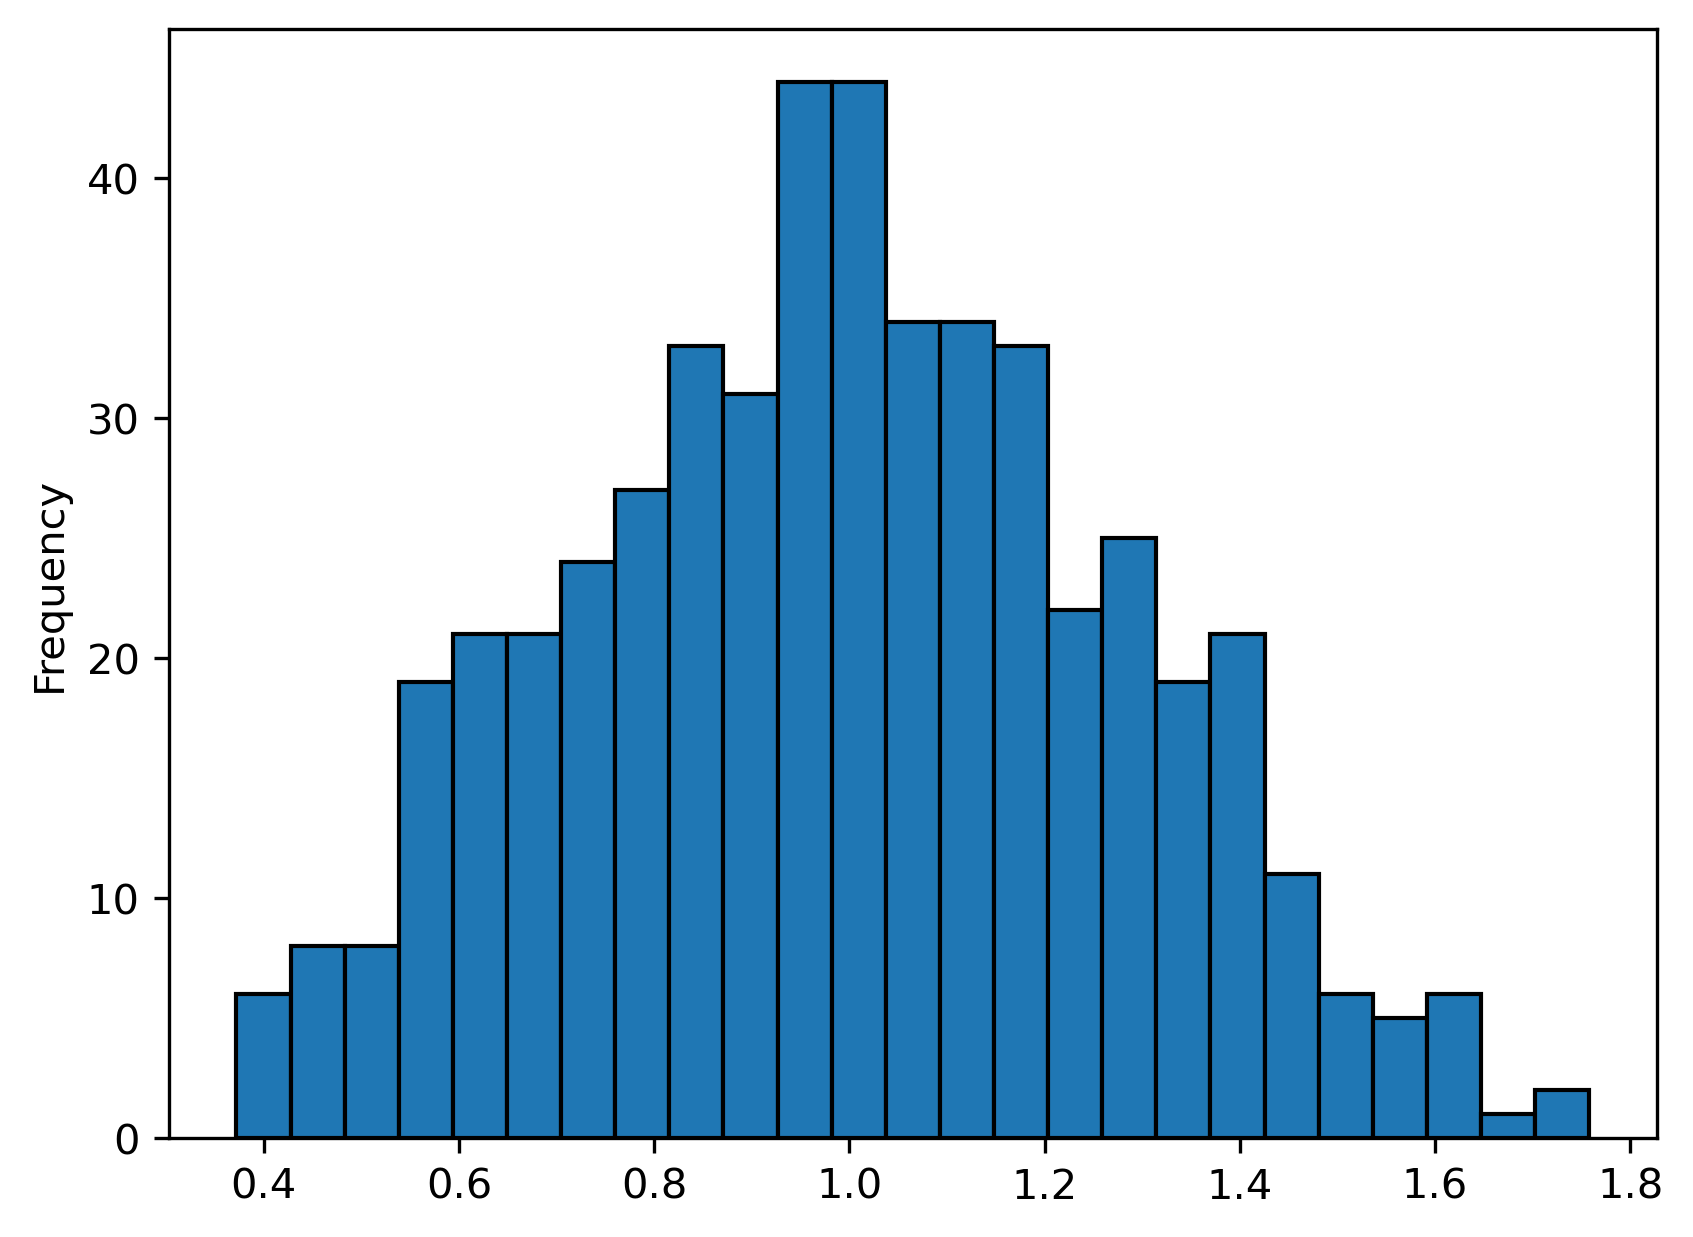

In [140]:
betas['RMRF'].plot.hist(bins=25, edgecolor='k');

In [142]:
betas['RMRF'].mean()

0.9971303854087371

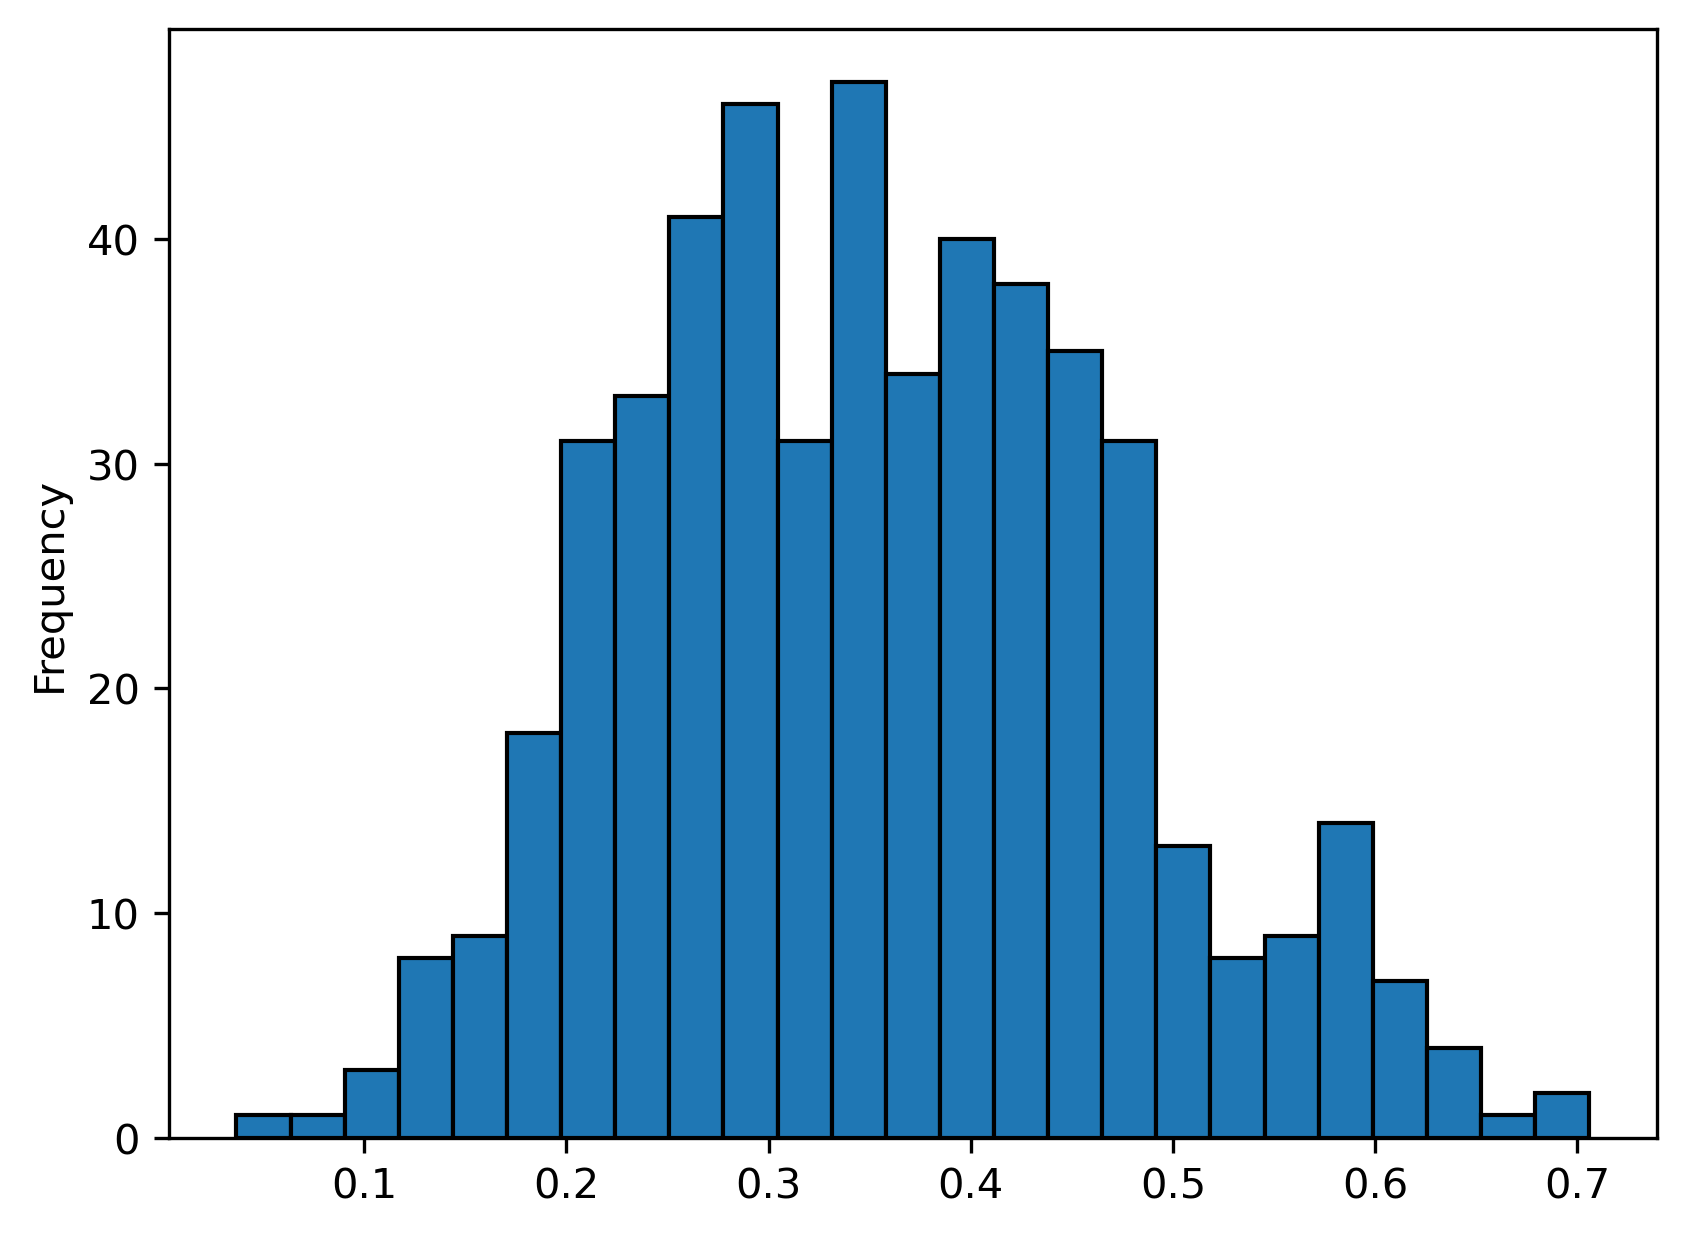

In [144]:
betas['R2'].plot.hist(bins=25, edgecolor='k');

In [146]:
betas['R2'].nlargest(5)

CFG    0.705908
AMP    0.693513
JPM    0.667765
PRU    0.643842
TFC    0.640156
Name: R2, dtype: float64

## Are alphas zero?

In [149]:
betas['const'].describe()

count    505.000000
mean       0.000303
std        0.000308
min       -0.001894
25%        0.000138
50%        0.000286
75%        0.000447
max        0.002181
Name: const, dtype: float64

To determine whether the $\alpha_i$ are statistically different from zero, we divide the average alpha by the [standard error of the mean](https://en.wikipedia.org/wiki/Standard_error),

$$\sigma_{\bar x} = \frac{\sigma}{\sqrt{N}}.$$

In [152]:
import scipy.stats as scs

scs.sem(betas['const'])

1.3720244200071954e-05

In [154]:
# t-statistic

betas['const'].mean() / scs.sem(betas['const'])

22.076688537743927

A $t$-statistic greater than 1.96 is “significant” at a 5% level. At the 1% level, the cutoff value is 2.58. The calculated statistic here is much, much higher than that. This is strong evidence that the $\alpha$s are not zero.

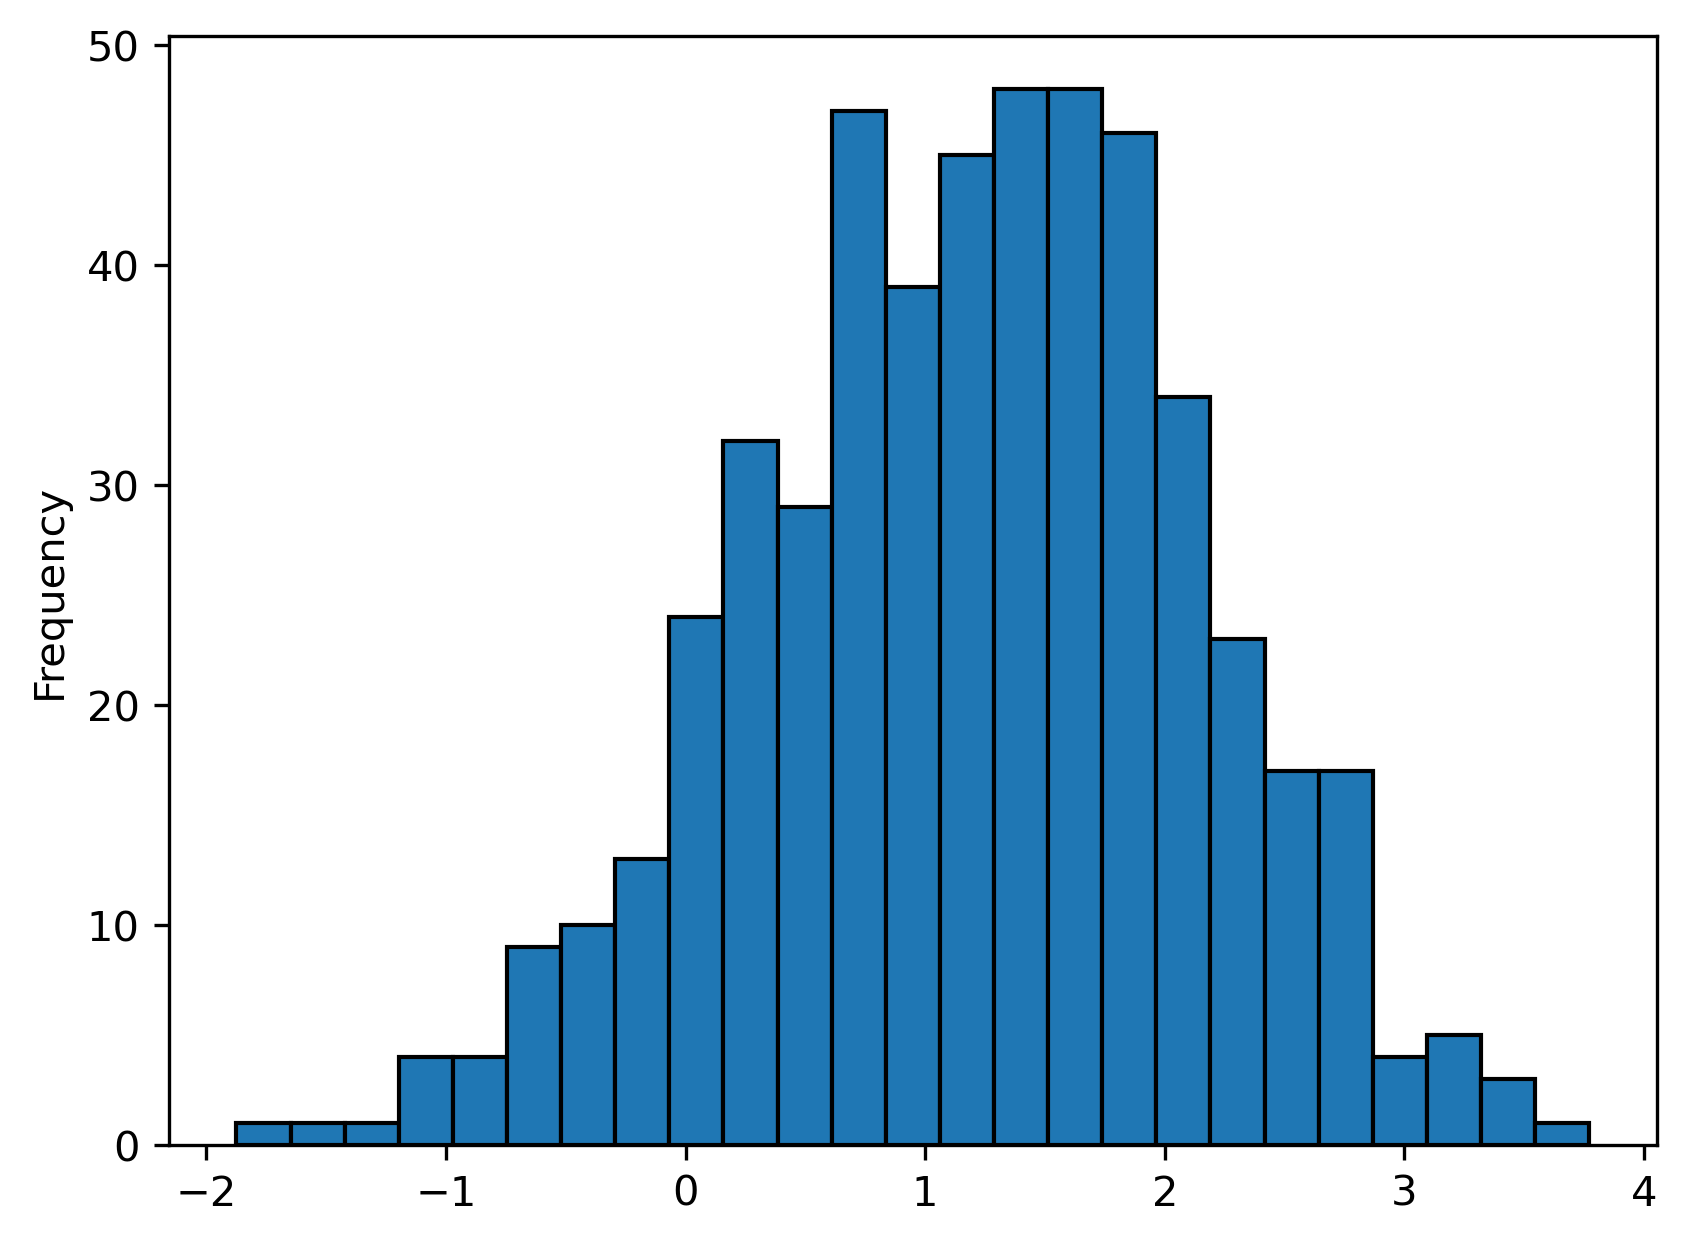

In [157]:
betas['t_const'].plot.hist(bins=25, edgecolor='k');

In [159]:
betas['t_const'].sort_values()

C      -1.873981
KVUE   -1.520599
GE     -1.351516
KHC    -1.169056
AIG    -1.049523
          ...   
NVDA    3.259356
IDXX    3.364967
TDG     3.408185
AAPL    3.471526
MNST    3.770911
Name: t_const, Length: 505, dtype: float64